In [69]:
import numpy as np
import pandas as pd
import tqdm
import jax
import jax.numpy as jnp
import string
import tensorflow as tf
import time
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

## Data Preprocessing

In [70]:
data = pd.read_csv('./data/raw data/raw_data.csv', header=0, names=['text'], usecols=[1])
print(f'Data Shape: {data.shape}')
data.head()

Data Shape: (13368, 1)


,text
0,"Sally Forrest, an actress-dancer who graced th..."
1,A middle-school teacher in China has inked hun...
2,A man convicted of killing the father and sist...
3,Avid rugby fan Prince Harry could barely watch...
4,A Triple M Radio producer has been inundated w...


In [71]:
# remove punctuation
punctuations = string.punctuation
def remove_punctuation(txt):
    for char in punctuations:
        if char in txt:
            txt = txt.replace(char, "")
    return txt

# change to lower caps
data['text'] = data['text'].str.lower()

# remove punctuations
data['text'] = data['text'].apply(remove_punctuation)

In [72]:
# remove stopwords
# read stopwords from data/raw data/stopwords.txt
stop_words = []
with open('./data/raw data/stopwords.txt', 'r') as f:
    for line in f:
        stop_words.append(line.strip())

def remove_stopwords(txt):
    txt = [word for word in txt.split() if word not in stop_words]
    return ' '.join(txt)

data['text'] = data['text'].apply(remove_stopwords)

In [86]:
stop_words

['a',
 'about',
 'above',
 'across',
 'after',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'among',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyone',
 'anything',
 'anywhere',
 'are',
 'area',
 'areas',
 'around',
 'as',
 'ask',
 'asked',
 'asking',
 'asks',
 'at',
 'away',
 'b',
 'back',
 'backed',
 'backing',
 'backs',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'been',
 'before',
 'began',
 'behind',
 'being',
 'beings',
 'best',
 'better',
 'between',
 'big',
 'both',
 'but',
 'by',
 'c',
 'came',
 'can',
 'cannot',
 'case',
 'cases',
 'certain',
 'certainly',
 'clear',
 'clearly',
 'come',
 'could',
 'd',
 'did',
 'differ',
 'different',
 'differently',
 'do',
 'does',
 'done',
 'down',
 'down',
 'downed',
 'downing',
 'downs',
 'during',
 'e',
 'each',
 'early',
 'either',
 'end',
 'ended',
 'ending',
 'ends',
 'enough',
 'even',
 'evenly',
 'ever',
 'every',
 'everybody',
 'everyone',
 'everything',

In [73]:
# split each row into list of words
data_lst = data['text'].apply(lambda txt: txt.split(" "))

# select number of rows to be used as training data
nrows = 200
random_indices = np.random.randint(low=0, high=len(data_lst), size=nrows)
data_lst = data_lst[random_indices].reset_index(drop=True)

print(f'Number of rows of data: {len(data_lst)}')
data_lst[:5]

Number of rows of data: 200


0    [stoke, goalkeeper, jack, butland, signed, con...
1    [ahead, weekends, premier, league, action, spo...
2    [bizarre, tribunal, hospital, employee, awarde...
3    [police, arrested, suspect, gangrape, elderly,...
4    [jeremy, clarkson, return, top, gear, ‘his, ow...
Name: text, dtype: object

In [74]:
# vocab dict
vocab, index = {}, 1
vocab['<pad>'] = 0
for line in data_lst:
    for word in line:
        if word not in vocab:
            vocab[word] = index
            index += 1

# inverse_vocab dict
inverse_vocab = {}
for word, index in vocab.items():
    inverse_vocab[index] = word

print(f'Vocab size: {len(vocab)}')

Vocab size: 15062


In [75]:
# sequences
sequences = []
for line in data_lst:
    vectorized_line = [vocab[word] for word in line]
    sequences.append(vectorized_line)

## Split Train and Test Sets

In [76]:
# split into train and test sets
# choose 20 random sequences
ntest = 20
test_indices = np.random.randint(low=0, high=len(sequences), size=ntest)
test_sequences = [sequences[i] for i in test_indices]
train_sequences = [sequences[i] for i in range(len(sequences)) if i not in test_indices]

In [77]:
# function to generate samples
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0,
          shuffle=True)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.reshape(tf.constant([context_word], dtype="int64"), (1,1))
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [78]:
# function to generate testing data
def generate_testing_data(sequences, vocab_size, window_size):
    targets, contexts, labels = [], [], []
    for sequence in tqdm(sequences):
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            window_size=window_size,
            negative_samples=0)
    for target_word, context_word in positive_skip_grams:
        targets.append(target_word)
        contexts.append(context_word)
        labels.append(1)
    return targets, contexts, labels

In [79]:
# generate training data
window_size = 5
num_ns = 4
vocab_size = len(vocab)
seed = 4212

targets, contexts, labels = generate_training_data(sequences=train_sequences,
                                                 window_size=window_size,
                                                 num_ns=num_ns,
                                                 vocab_size=vocab_size,
                                                 seed=seed)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print(f'targets shape: {targets.shape}')
print(f'contexts shape: {contexts.shape}')
print(f'labels shape: {labels.shape}')

100%|██████████| 183/183 [02:30<00:00,  1.22it/s]


targets shape: (320653,)
contexts shape: (320653, 5)
labels shape: (320653, 5)


In [87]:
# generate testing data
targets_test, contexts_test, labels_test = generate_testing_data(sequences=test_sequences,
                                                                    vocab_size=vocab_size,
                                                                    window_size=window_size)

targets_test = np.array(targets_test)
contexts_test = np.array(contexts_test)
labels_test = np.array(labels_test)

print(f'targets_test shape: {targets_test.shape}')
print(f'contexts_test shape: {contexts_test.shape}')
print(f'labels_test shape: {labels_test.shape}')

100%|██████████| 20/20 [00:00<00:00, 140.68it/s]

targets_test shape: (1200,)
contexts_test shape: (1200,)
labels_test shape: (1200,)


**Sanity Check on quality of training and testing data**

In [89]:
# training data
print(f"target_index    : {targets[0]}")
print(f"target_word     : {inverse_vocab[targets[0]]}")
print(f"context_indices : {contexts[0]}")
print(f"context_words   : {[inverse_vocab[c] for c in contexts[0]]}")
print(f"label           : {labels[0]}")

print("target  :", targets[0])
print("context :", contexts[0])
print("label   :", labels[0])

target_index    : 32
target_word     : £4million
context_indices : [   1   39 1601 1612 1079]
context_words   : ['stoke', 'england', 'dwynwens', 'downgrade', 'womans']
label           : [1 0 0 0 0]
target  : 32
context : [   1   39 1601 1612 1079]
label   : [1 0 0 0 0]


In [90]:
# testing data
print(f"target_index    : {targets_test[0]}")
print(f"target_word     : {inverse_vocab[targets_test[0]]}")
print(f"context_index : {contexts_test[0]}")
print(f"context_word   : {inverse_vocab[contexts_test[0]]}")
print(f"label           : {labels_test[0]}")

print("target  :", targets_test[0])
print("context :", contexts_test[0])
print("label   :", labels_test[0])

target_index    : 392
target_word     : police
context_index : 3025
context_word   : tuesday
label           : 1
target  : 392
context : 3025
label   : 1


## Minimizing Objective Function for SGNS

$$

\min_{\theta} = \frac{1}{N} \sum_{i=1}^{N} [log \sigma(u_{ic}^T)  + \sum_{k=1}^{K}log \sigma(-u_{kc}^T v_{iw})]

\\
\\
\theta = [U, V]

$$

In [91]:
# sigmoid function
def sigmoid(x):
    """Inputs a real number, outputs a real number"""
    return 1 / (1 + jnp.exp(-x))

# define a local loss function
# where it takes a params argument where params = [U, V]
# U and V are the embedding matrices. Dimension of U : (n x |v|), Dimension of V : (|v| x n)
# target is the index of the target word vector in the V matrix. Dimension: (1,)
# context is the index of the context word vectors in the U matrix. Dimension: (n,)
# returns a real number

def local_loss(params,
               target,
               context):
    """
    Input (example)
    target = (188,)
    context = (93, 40, 1648, 1659, 1109)
    params = [V, U]
        V: matrix of dim (n x |v|)
        U: matrix of dim (|v| x n)
            n = embedding dimension, |v| = vocab size

    Outputs the local_loss -> real number
    """
    target = target.astype(int)
    context = context.astype(int)
    V_embedding =params[0][0]
    U_embedding = params[0][1]
    
    v_t = V_embedding.T[target]; print(f'v_t shape: {v_t.shape}') # shape (300,)
    u_pos = U_embedding[context[0]]; print(f'u_pos shape: {u_pos.shape}')  # shape(300,)
    u_neg = U_embedding[context[1:]]; print(f'u_neg shape: {u_neg.shape}')  # shape(4, 300)

    return -jnp.log(sigmoid(jnp.dot(u_pos.T, v_t))) - jnp.sum(jnp.log(sigmoid(-jnp.dot(u_neg, v_t))))


In [92]:
# vmap the local loss across a batch of data points
loss_all = jax.vmap(local_loss, in_axes=(None, 0, 0))

@jax.jit
def loss(params, targets, contexts):
    """return average of all the local losses"""
    all_losses = loss_all(params, targets, contexts)
    return jnp.mean(all_losses)

# get the loss value and gradient
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [98]:
# set up
n = 200
v = len(vocab)
V = np.random.normal(0, 1, size=(n, v)) / np.sqrt(v)
U = np.random.normal(0, 1, size=(v, n)) / np.sqrt(v)
params = [(V, U)]
targets_data = targets.astype(float)
contexts_data = contexts.astype(float)
labels_data = labels.astype(float)

print(f'V shape: {V.shape}')
print(f'U shape: {U.shape}')
print(f'targets_data shape: {targets_data.shape}')
print(f'contexts_data shape: {contexts_data.shape}')
print(f'labels_data shape: {labels_data.shape}')

V shape: (200, 15062)
U shape: (15062, 200)
targets_data shape: (320653,)
contexts_data shape: (320653, 5)
labels_data shape: (320653, 5)


In [99]:
# train using stochastic gradient descent

# number of training examples
N = len(targets_data)

# learning rate
lr = 3.

# number of epochs
n_epochs = 10

# batch size
batch_size = 500

# number of batches per epoch
n_batches = N // batch_size

# keep track of losses
epoch_losses = []

# training the network
for epoch in range(n_epochs):
    start_time = time.time()
    # shuffle data
    perm = np.random.permutation(N)
    targets = targets[perm]
    contexts = contexts[perm]
    labels = labels[perm]

    # half the learning rate every 25 epochs
    # if epoch % 25 == 0 and epoch != 0:
    #    lr /= 2.

    # losses in each epoch
    losses = []
    for batch in range(n_batches):
        targets_batch = targets_data[batch*batch_size: (batch+1)*batch_size]
        contexts_batch = contexts_data[batch*batch_size: (batch+1)*batch_size]
        labels_batch = labels_data[batch*batch_size: (batch+1)*batch_size]

        # calculate and save losses
        loss_value, gradient = loss_value_and_grad(params, targets_batch, contexts_batch)
        losses.append(loss_value)

        params = [(V - lr*dV, U - lr*dU) for (V, U), (dV, dU) in zip(params, gradient)]

    epoch_losses.append(np.mean(losses))

    end_time = time.time()
    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} \t loss = {np.mean(epoch_losses)} \t time = {end_time - start_time:.2f}s")

v_t shape: (200,)
u_pos shape: (200,)
u_neg shape: (4, 200)
Epoch 1/10 	 loss = 3.440905809402466 	 time = 20.04s
Epoch 2/10 	 loss = 3.1278157234191895 	 time = 19.03s
Epoch 3/10 	 loss = 2.8392622470855713 	 time = 18.95s
Epoch 4/10 	 loss = 2.6382155418395996 	 time = 18.88s
Epoch 5/10 	 loss = 2.492654323577881 	 time = 19.03s
Epoch 6/10 	 loss = 2.382213592529297 	 time = 19.03s
Epoch 7/10 	 loss = 2.295213222503662 	 time = 19.01s
Epoch 8/10 	 loss = 2.2246487140655518 	 time = 19.01s
Epoch 9/10 	 loss = 2.166088104248047 	 time = 19.04s
Epoch 10/10 	 loss = 2.116589069366455 	 time = 19.08s


Text(0, 0.5, 'Loss')

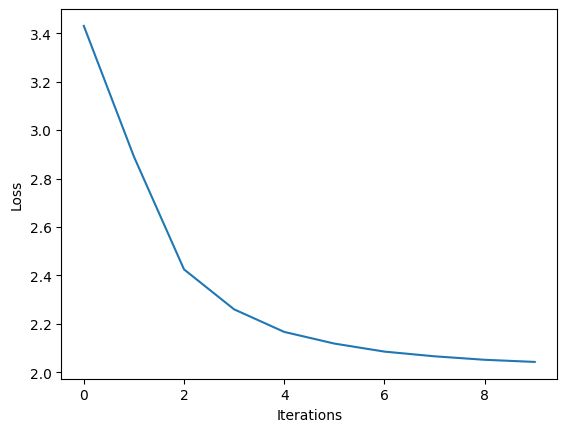

In [95]:
# plot losses
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [34]:
V_ = np.copy(params[0][0])
U_ = np.copy(params[0][1])

# check dimensions of U and V, 10 epoch, 1r = 3, 1.5, 0.75, batch size = 500
print(f'V_ shape: {V_.shape}')
print(f'U_ shape: {U_.shape}')

V_ shape: (300, 14806)
U_ shape: (14806, 300)


In [21]:
# copy U and V
V_trained = np.copy(params[0][0])
U_trained = np.copy(params[0][1])

# check dimensions of U and V, 100 epochs, lr = 1, batch_size = 500
print(f'V_trained shape: {V_trained.shape}')
print(f'U_trained shape: {U_trained.shape}')

V_trained shape: (300, 14806)
U_trained shape: (14806, 300)


## Evaluate against test set

In [19]:
# define function that takes in an index and vocab size and returns the one-hot encoding
def getOneHot(index, vocab_size):
    onehot = np.zeros(vocab_size)
    onehot[index] = 1
    return onehot

# define softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# test getOneHot and softmax function
print(getOneHot(1, 10))
print(softmax(np.array([1, 2, 3])))


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.09003057 0.24472847 0.66524096]


In [20]:
# check dimensions of U and V
print(f'U shape: {U.shape}')
print(f'V shape: {V.shape}')

U shape: (14806, 300)
V shape: (300, 14806)


In [50]:
# see first 20 words in the vocab
test_words = list(vocab.keys())[20:40]
test_words

['what',
 'appears',
 'to',
 'be',
 'homeless',
 'woman',
 'in',
 'paris',
 'reading',
 'the',
 'famed',
 'magazine',
 'is',
 'full',
 'surprisesand',
 'voguemagazine',
 'readers',
 'even',
 'unexpected',
 'corners']

In [29]:
# define cosine similarity scores between 2 word vectors
def similarity_score(target_word_embedding, context_word_embedding):
    return np.dot(target_word_embedding, context_word_embedding) / (np.linalg.norm(target_word_embedding) * np.linalg.norm(context_word_embedding))

# define a function that find the most similar words to a given word
def most_similar_words(word, V, n=5):
    scores = []
    target_word_idx = vocab[word]
    for i in range(V.shape[1]):
        if i == target_word_idx or inverse_vocab[i] == '<pad>':
            continue
        scores.append((inverse_vocab[i], similarity_score(V[:, target_word_idx], V[:, i])))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return scores[:n]

In [51]:
# check similarity between words
# word: photos
print(most_similar_words('photos', V_trained))

# word: saturday
print(most_similar_words('saturday', V_trained))

[('subsequent', 0.869424), ('fortyseven', 0.86821645), ('hayler', 0.8639586), ('livein', 0.8605932), ('steal', 0.8605353)]
[('lorries', 0.82925045), ('deported', 0.8283184), ('19090', 0.8239643), ('phased', 0.8218111), ('precious', 0.8180679)]


In [36]:
# check similarity between words
# word: photos
print(most_similar_words('photos', V_))

# word: saturday
print(most_similar_words('saturday', V_))

[('hayler', 0.8091358), ('dangerous', 0.80723435), ('fortyseven', 0.8031516), ('franken', 0.80080813), ('steal', 0.7987832)]
[('lorries', 0.77739894), ('deported', 0.7672179), ('19090', 0.7604412), ('precious', 0.7562994), ('unturned’', 0.7544449)]


In [48]:
# compute a forward pass through the skip-gram model

# define the forward pass function
def net(V, U, target_word_idx):
    target_hot = getOneHot(target_word_idx, len(vocab))
    return softmax( U @ V @ target_hot )

def predict(word, V, U):
    target_word_idx = vocab[word]
    y_hat = net(V, U, target_word_idx)
    # y_hat is the probability distribution over the vocab
    # select the top 5 words with the highest probability
    top_5 = np.argsort(y_hat)[-10:][::-1]
    top_5_words = [inverse_vocab[i] for i in top_5]
    return top_5_words

In [56]:
word = 'photos'
y_hat = net(V_, U_, vocab[word])
predict(word, V_, U_)

['and', '', 'the', 'her', 'he', 'was', 'his', 'she', 'said', 'of']

In [39]:
type(y_hat)

numpy.ndarray